In [2]:
import tensorflow as tf
import keras
from tensorflow import keras
import kagglehub


from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

import os
import cv2
import numpy as np
from imgaug import augmenters as iaa

from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

2024-12-04 09:30:26.614892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
train_images = os.path.join(path, 'asl_alphabet_train', 'asl_alphabet_train')

# Augmentation Sequence
augmentation = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),  # Rotate images within [-10, 10] degrees
    iaa.AddToBrightness((-2, 2)),  # Adjust brightness
    iaa.AdditiveGaussianNoise(scale=(0, 0.001 * 255)),  # Add Gaussian noise
    iaa.Crop(percent=(0, 0.1))  # Crop by up to 10% from each side
])
# Function to convert BGR to RGB for display
def convert_bgr_to_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Data loading and augmentation
def get_data_with_augmentation(data_dir):
    images = []
    labels = []

    dir_list = os.listdir(data_dir)
    for i, label in enumerate(dir_list):
        print("Obtaining and augmenting images of", label, "...")
        for image in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, image)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (32, 32))
            
            # Append the original image
            images.append(img)
            labels.append(i)

            # Apply augmentations
            img_augmented = augmentation(images=[img] * 2)  
            images.extend(img_augmented)
            labels.extend([i] * len(img_augmented))

    return np.array(images), np.array(labels)

# Loading data with augmentation
X, y = get_data_with_augmentation(train_images)

print("Dataset Size (including originals and augmentations):", len(X))


Obtaining and augmenting images of R ...
Obtaining and augmenting images of U ...
Obtaining and augmenting images of I ...
Obtaining and augmenting images of N ...
Obtaining and augmenting images of G ...
Obtaining and augmenting images of Z ...
Obtaining and augmenting images of T ...
Obtaining and augmenting images of S ...
Obtaining and augmenting images of A ...
Obtaining and augmenting images of F ...
Obtaining and augmenting images of O ...
Obtaining and augmenting images of H ...
Obtaining and augmenting images of del ...
Obtaining and augmenting images of nothing ...
Obtaining and augmenting images of space ...
Obtaining and augmenting images of M ...
Obtaining and augmenting images of J ...
Obtaining and augmenting images of C ...
Obtaining and augmenting images of D ...
Obtaining and augmenting images of V ...
Obtaining and augmenting images of Q ...
Obtaining and augmenting images of X ...
Obtaining and augmenting images of E ...
Obtaining and augmenting images of B ...
Obta

In [43]:
# Split into Training and Test
import sklearn
from sklearn.model_selection import train_test_split

labels = [
    'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 
    'del', 'nothing', 'space', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 
    'E', 'B', 'K', 'L', 'Y', 'P', 'W'
]

X = np.array(X)
y = np.array(y)

# Normalizing
X_normalized = X.astype('float32') / 255.0

# Training and Test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Shapes
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")


# Encoding
y_train_encoded = to_categorical(y_train, num_classes=len(labels))
y_test_encoded = to_categorical(y_test, num_classes=len(labels))

y_train_encoded
y_test_encoded


Training data shape: (182700, 32, 32, 3), Test data shape: (78300, 32, 32, 3)
Training labels shape: (182700,), Test labels shape: (78300,)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [44]:
classes = 29
batch = 64
epochs = 10
learning_rate = 0.001

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
from tensorflow.keras.regularizers import l2

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(classes, activation='softmax'))


early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=2,              
    restore_best_weights=True 
)
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Compile the model with SGD
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with SGD
history = model.fit(
    X_train, 
    y_train_encoded, 
    batch_size=batch, 
    epochs=epochs, 
    validation_split=0.3, 
    shuffle=True, 
    verbose=1, 
    callbacks=[early_stopping]
)


Epoch 1/10
1999/1999 [==============================] - 166s 83ms/step - loss: 10.7043 - accuracy: 0.6436 - val_loss: 7.0107 - val_accuracy: 0.7614
Epoch 2/10
1999/1999 [==============================] - 233s 117ms/step - loss: 4.7398 - accuracy: 0.8977 - val_loss: 3.1899 - val_accuracy: 0.9253
Epoch 3/10
1999/1999 [==============================] - 225s 113ms/step - loss: 2.2537 - accuracy: 0.9503 - val_loss: 1.6519 - val_accuracy: 0.9262
Epoch 4/10
1999/1999 [==============================] - 140s 70ms/step - loss: 1.1362 - accuracy: 0.9694 - val_loss: 1.0572 - val_accuracy: 0.8801
Epoch 5/10
1999/1999 [==============================] - 141s 70ms/step - loss: 0.6224 - accuracy: 0.9779 - val_loss: 0.4753 - val_accuracy: 0.9798
Epoch 6/10
1999/1999 [==============================] - 150s 75ms/step - loss: 0.3803 - accuracy: 0.9833 - val_loss: 0.4687 - val_accuracy: 0.9272
Epoch 7/10
1999/1999 [==============================] - 137s 69ms/step - loss: 0.2639 - accuracy: 0.9860 - val_loss

In [45]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


2447/2447 [==============================] - 26s 11ms/step - loss: 0.1550 - accuracy: 0.9838
Test Loss: 0.1550, Test Accuracy: 0.9838


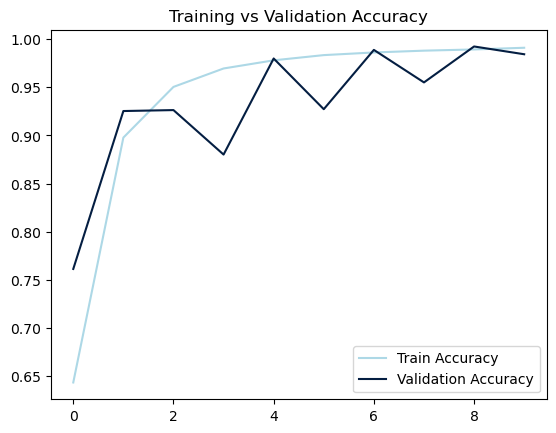

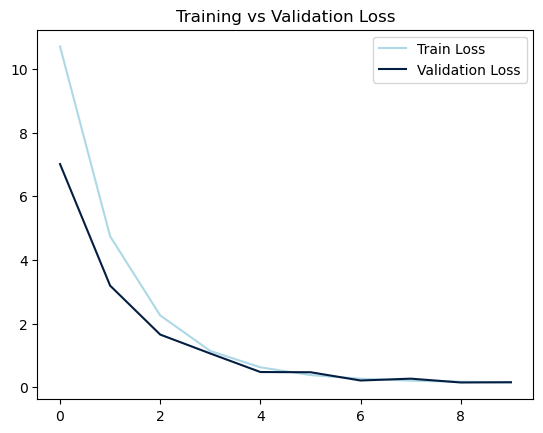

In [46]:
# Training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#ADD8E6')  # Training color
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#041E42')  # Validation color
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Training and validation loss
plt.plot(history.history['loss'], label='Train Loss', color='#ADD8E6')  # Training color
plt.plot(history.history['val_loss'], label='Validation Loss', color='#041E42')  # Validation color
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [47]:
# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Classification report
print(classification_report(y_test_classes, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)


2447/2447 [==============================] - 25s 10ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2642
           1       0.87      1.00      0.93      2682
           2       1.00      0.99      0.99      2622
           3       1.00      0.93      0.96      2806
           4       1.00      1.00      1.00      2757
           5       1.00      0.99      0.99      2643
           6       1.00      0.98      0.99      2667
           7       0.92      1.00      0.96      2755
           8       1.00      0.97      0.99      2733
           9       1.00      0.99      1.00      2569
          10       1.00      0.98      0.99      2660
          11       1.00      0.99      1.00      2702
          12       1.00      0.99      0.99      2704
          13       0.98      1.00      0.99      2736
          14       1.00      1.00      1.00      2619
          15       0.92      1.00      0.96      2747
          16       1.0

In [50]:
model.save('labeled2.h5')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img_path = '/Users/kendallgilbert/Desktop/ASL_APP/ASL_Data/asl_alphabet_test/asl_alphabet_test/C_test.jpg'
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (32, 32))
img_rgb = convert_bgr_to_rgb(img_resized)
img_normalized = img_rgb.astype('float32') / 255.0
img_batch = np.expand_dims(img_normalized, axis=0)
y_pred = model.predict(img_batch)

y_pred_class = np.argmax(y_pred, axis=1)[0]

labels = [
    'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 
    'del', 'nothing', 'space', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 
    'E', 'B', 'K', 'L', 'Y', 'P', 'W'
]

predicted_label = labels[y_pred_class]

print(f"The predicted class for the image is: {predicted_label}")


1/1 [==============================] - 0s 15ms/step
The predicted class for the image is: C
